In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/netflix-prize-data/combined_data_3.txt
/kaggle/input/netflix-prize-data/movie_titles.csv
/kaggle/input/netflix-prize-data/combined_data_4.txt
/kaggle/input/netflix-prize-data/combined_data_1.txt
/kaggle/input/netflix-prize-data/README
/kaggle/input/netflix-prize-data/probe.txt
/kaggle/input/netflix-prize-data/combined_data_2.txt
/kaggle/input/netflix-prize-data/qualifying.txt


In [2]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

from sklearn.decomposition import TruncatedSVD

import random

import os

In [3]:
files = ['/kaggle/input/netflix-prize-data/combined_data_1.txt',
        '/kaggle/input/netflix-prize-data/combined_data_2.txt',
        '/kaggle/input/netflix-prize-data/combined_data_3.txt',
        '/kaggle/input/netflix-prize-data/combined_data_4.txt']

In [4]:
data = open('data.csv','w')
row = list()
i=1

for file in files:
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                movie_id = line.replace(':','')
            else:
                row = [x for x in line.split(',')]
                row.insert(0,movie_id)
                data.write(','.join(row))
                data.write('\n')
    print('Finished file {}'.format(i))
    i+=1
data.close()

Finished file 1
Finished file 2
Finished file 3
Finished file 4


In [5]:
df = pd.read_csv('/kaggle/working/data.csv',sep=',',names=['movie','user','rating','date'])

In [6]:
os.remove('/kaggle/working/data.csv')

In [7]:
df.columns


Index(['movie', 'user', 'rating', 'date'], dtype='object')

In [8]:
df.sort_values(by=['date'],inplace=True,ignore_index=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

movie     0
user      0
rating    0
date      0
dtype: int64

In [11]:
df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [12]:
def create_train_test(df):
    if not os.path.isfile('/kaggle/working/train.csv'):
        df.iloc[:int(df.shape[0]*0.8)].to_csv('/kaggle/working/train.csv')
    if not os.path.isfile('/kaggle/working/data.csv/test.csv'):
        df.iloc[int(df.shape[0]*0.8):].to_csv('/kaggle/working/test.csv')
        

In [13]:
create_train_test(df)
del df

In [14]:
train = pd.read_csv('/kaggle/working/train.csv',parse_dates=['date'])
os.remove('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
os.remove('/kaggle/working/test.csv')

In [15]:
train.drop('date',1,inplace=True)
test.drop('date',1,inplace = True)

In [16]:
train.head()

,Unnamed: 0,movie,user,rating
0,0,10341,510180,4
1,1,1798,510180,5
2,2,10774,510180,3
3,3,8651,510180,2
4,4,14660,510180,2


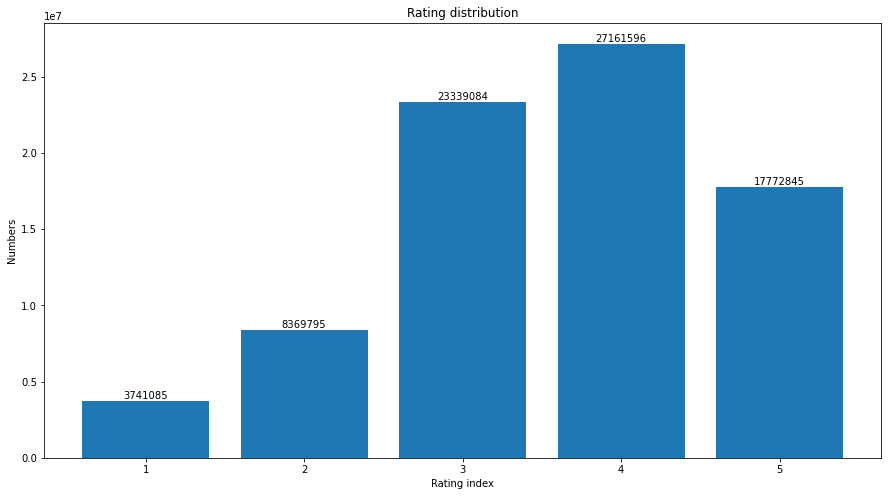

In [17]:
c = train['rating'].value_counts()

plt.figure(figsize=(15,8))
ax = plt.bar(c.index,c.values)
plt.bar_label(ax,c.values)
plt.title('Rating distribution')
plt.xlabel('Rating index')
plt.ylabel('Numbers')
plt.show()

* Most of the ratingds are positive and 3-4.

In [18]:
g = train.groupby('user')['rating'].count()
g = dict( sorted(g.items(), key=lambda x:x[1] ,reverse=True)[0:5])
g


{305344: 17112, 2439493: 15896, 387418: 15402, 1639792: 9767, 1461435: 9447}

# Creating sparse-matrix

In [19]:
sparse_train = sparse.csr_matrix((train.rating.values,(train.user.values,train.movie.values)),)

In [20]:
print(sparse_train.shape)

(2649430, 17771)


# Movie-Movie Similarity matrix  

In [21]:
sim = cosine_similarity(X=sparse_train.T,dense_output=False)

In [22]:
movie_ids = np.unique(sim.nonzero()[1])
movie_ids[0:5]

array([1, 2, 3, 4, 5], dtype=int32)

In [23]:
sim.shape

(17771, 17771)

In [24]:
similar_movies = dict()
for i in movie_ids:
    sim_movies = sim[i].toarray().ravel().argsort()[::-1][1:]
    similar_movies[i] = sim_movies[0:20]

In [25]:
similar_movies[15]

array([ 8279,  8013, 16528,  5927, 13105, 12049,  4424, 10193, 17590,
        4549,  3755,   590, 14059, 15144, 15054,  9584,  9071,  6349,
       16402,  3973])

In [26]:
names=pd.read_csv('/kaggle/input/netflix-prize-data/movie_titles.csv',sep=',',names=['movie_id','year','title'],index_col='movie_id',encoding='ISO-8859-1')

In [27]:
names.head()

,year,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# Results

In [28]:
names.loc[1]

year              2003.0
title    Dinosaur Planet
Name: 1, dtype: object

# Similar movies to Dinosaur Planet 

In [29]:
names.loc[similar_movies[1]]

,year,title
movie_id,,
694,2000.0,When Dinosaurs Roamed America
5302,2003.0,Chased by Dinosaurs: Three Walking with Dinosa...
1084,2001.0,Walking with Prehistoric Beasts
13586,2001.0,Allosaurus: A Walking with Dinosaurs Special
1173,1999.0,Walking with Dinosaurs
4181,2003.0,Walking with Cavemen
8800,2003.0,Prehistoric America: A Journey Through the Ice...
10656,2003.0,Before We Ruled the Earth: Mastering the Beasts
15648,2002.0,National Geographic: Dinosaur Hunters: Secrets...
